# Demonstration of Super Learner

The following is a simple simulation study to demonstrate the performance of super-learner and constrast it with all of the candidate estimators being used for a variety of simulated data mechanisms. 

The mechanisms come from Polley & van der Laan 2010. In all 4 data generating mechanisms, the best $R^2$ for the true model is 0.8. Therefore, estimated $R^2$ above that level indicates over-fitting. Ideal performance is indicated as close to 0.8 in the plots. For this comparison, I was inspired by Keil et al. 2018, where they demonstrate an implementation in SAS. 


## References

Van der Laan, M. J., Polley, E. C., & Hubbard, A. E. (2007). Super learner. Statistical applications in genetics and molecular biology, 6(1).

Polley, E. C., & Van der Laan, M. J. (2010). Super learner in prediction.

Keil, A. P., Westreich, D., Edwards, J. K., & Cole, S. R. (2018). Super learning in the SAS system. arXiv preprint arXiv:1805.08058.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn

from sklearn.linear_model import LinearRegression
from pygam import GAM, LinearGAM, s
from sklearn.ensemble import (RandomForestRegressor, BaggingRegressor,
                              GradientBoostingRegressor)
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from pyearth import Earth

from zepid.superlearner import EmpiricalMeanSL, StepwiseSL
from zepid.superlearner import SuperLearner

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

sims = 100
labels = ["Mean", "LinR", "Step.int", "RandFor", "Bagging", "GAM-2", "GAM-3", "GAM-4", "Boost",
          "NN-2", "NN-3", "NN-4", "NN-5", "MARS", "KNN-30", "KNN-20", "KNN-10", "KNN-5"]

In [2]:
def dgm(n, version):
    # Generating Data
    x = np.random.uniform(-4, 4, size=n)
    if version == 1:
        y = (-2*np.where(x<-3, 1, 0) + 2.55*np.where(x>-2, 1, 0) - 2*np.where(x>0, 1, 0) +
             4*np.where(x>2, 1, 0) - np.where(x>3, 1, 0) + np.random.normal(size=n))
    elif version == 2:
        y = 6 + 0.4*x - 0.36*(x**2) + 0.005*(x**3) + np.random.normal(size=n)
    elif version == 3:
        y = 2.83*np.sin(np.pi / 2 * x) + np.random.normal(size=n)
    elif version == 4:
        y = 4*np.sin(3*np.pi*x)*np.where(x>0, 1, 0) + np.random.normal(size=n)
    else:
        raise ValueError("Invalid DGM")

    d = pd.DataFrame()
    d['X'] = x
    d['Y'] = y
    return d


def eval_rsquared(y_true, y_pred):
    num = np.sum((y_true - y_pred)**2)
    den = np.sum((y_true - np.mean(y_true))**2)
    return 1 - (num/den)


def eval_mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)


def run_single_sim(i, n_obs, version, results):
    obs_data = dgm(n=n_obs, version=version)
    x_train = np.asarray(obs_data['X']).reshape(-1, 1)
    y_train = np.asarray(obs_data['Y'])
    oos_data = dgm(n=10000, version=version)
    x_test = np.asarray(oos_data['X']).reshape(-1, 1)
    y_test = np.asarray(oos_data['Y'])

    # Empirical Mean
    emp = EmpiricalMeanSL()
    emp.fit(x_train, y_train)
    y_pred_emp = emp.predict(x_test)
    results.loc[i, "Mean"] = eval_rsquared(y_test, y_pred_emp)

    # LinearRegression
    ols = LinearRegression(fit_intercept=True)
    ols.fit(x_train, y_train)
    y_pred_ols = ols.predict(x_test)
    results.loc[i, "LinR"] = eval_rsquared(y_test, y_pred_ols)

    # Stepwise
    f = sm.families.family.Gaussian()
    step = StepwiseSL(f, selection="backward", order_interaction=1)
    step.fit(x_train, y_train)
    y_pred_step = step.predict(x_test)
    results.loc[i, "Step.int"] = eval_rsquared(y_test, y_pred_step)

    # Random Forest
    randf = RandomForestRegressor()
    randf.fit(x_train, y_train)
    y_pred_rf = randf.predict(x_test)
    results.loc[i, "RandFor"] = eval_rsquared(y_test, y_pred_rf)

    # Bagging
    bagr = BaggingRegressor()
    bagr.fit(x_train, y_train)
    y_pred_bag = bagr.predict(x_test)
    results.loc[i, "Bagging"] = eval_rsquared(y_test, y_pred_bag)

    # GAM -- 2
    gam2 = LinearGAM(s(0, n_splines=5, spline_order=1), lam=1)
    gam2.fit(x_train, y_train)
    y_pred_gam2 = gam2.predict(x_test)
    results.loc[i, "GAM-2"] = eval_rsquared(y_test, y_pred_gam2)

    # GAM -- 3
    gam3 = LinearGAM(s(0, n_splines=10, spline_order=2), lam=1)
    gam3.fit(x_train, y_train)
    y_pred_gam3 = gam3.predict(x_test)
    results.loc[i, "GAM-3"] = eval_rsquared(y_test, y_pred_gam3)

    # GAM -- 4
    gam4 = LinearGAM(s(0, n_splines=20), lam=1)
    gam4.fit(x_train, y_train)
    y_pred_gam4 = gam4.predict(x_test)
    results.loc[i, "GAM-4"] = eval_rsquared(y_test, y_pred_gam4)

    # Boosting
    gbr = GradientBoostingRegressor()
    gbr.fit(x_train, y_train)
    y_pred_gbr = gbr.predict(x_test)
    results.loc[i, "Boost"] = eval_rsquared(y_test, y_pred_gbr)

    # Neural Network -- 2 nodes
    nn2 = MLPRegressor(hidden_layer_sizes=(2,), solver='lbfgs', max_iter=2000)
    nn2.fit(x_train, y_train)
    y_pred_nn2 = nn2.predict(x_test)
    results.loc[i, "NN-2"] = eval_rsquared(y_test, y_pred_nn2)

    # Neural Network -- 3 nodes
    nn3 = MLPRegressor(hidden_layer_sizes=(3,), solver='lbfgs', max_iter=2000)
    nn3.fit(x_train, y_train)
    y_pred_nn3 = nn3.predict(x_test)
    results.loc[i, "NN-3"] = eval_rsquared(y_test, y_pred_nn3)

    # Neural Network -- 4 nodes
    nn4 = MLPRegressor(hidden_layer_sizes=(4,), solver='lbfgs', max_iter=2000)
    nn4.fit(x_train, y_train)
    y_pred_nn4 = nn4.predict(x_test)
    results.loc[i, "NN-4"] = eval_rsquared(y_test, y_pred_nn4)

    # Neural Network -- 5 nodes
    nn5 = MLPRegressor(hidden_layer_sizes=(5,), solver='lbfgs', max_iter=2000)
    nn5.fit(x_train, y_train)
    y_pred_nn5 = nn5.predict(x_test)
    results.loc[i, "NN-5"] = eval_rsquared(y_test, y_pred_nn5)

    # MARS
    mars = Earth()
    mars.fit(x_train, y_train)
    y_pred_mars = mars.predict(x_test)
    results.loc[i, "MARS"] = eval_rsquared(y_test, y_pred_mars)

    # KNN - 75NN
    knn75 = KNeighborsRegressor(n_neighbors=30)
    knn75.fit(x_train, y_train)
    y_pred_knn75 = knn75.predict(x_test)
    results.loc[i, "KNN-30"] = eval_rsquared(y_test, y_pred_knn75)

    # KNN - 50NN
    knn50 = KNeighborsRegressor(n_neighbors=20)
    knn50.fit(x_train, y_train)
    y_pred_knn50 = knn50.predict(x_test)
    results.loc[i, "KNN-20"] = eval_rsquared(y_test, y_pred_knn50)

    # KNN - 25NN
    knn25 = KNeighborsRegressor(n_neighbors=10)
    knn25.fit(x_train, y_train)
    y_pred_knn25 = knn25.predict(x_test)
    results.loc[i, "KNN-10"] = eval_rsquared(y_test, y_pred_knn25)

    # KNN - 10NN
    knn10 = KNeighborsRegressor(n_neighbors=5)
    knn10.fit(x_train, y_train)
    y_pred_knn10 = knn10.predict(x_test)
    results.loc[i, "KNN-5"] = eval_rsquared(y_test, y_pred_knn10)

    # Discrete Super Learner
    candidates = [EmpiricalMeanSL(),
                  LinearRegression(fit_intercept=True),
                  StepwiseSL(f, selection="backward", order_interaction=1),
                  RandomForestRegressor(),
                  BaggingRegressor(),
                  GAM(s(0, n_splines=2, spline_order=1), link="identity", lam=0.5),
                  GAM(s(0, n_splines=3, spline_order=2), link="identity", lam=0.5),
                  GAM(s(0, n_splines=4), link="identity", lam=0.5),
                  GradientBoostingRegressor(),
                  MLPRegressor(hidden_layer_sizes=(2,), solver='lbfgs', max_iter=2000),
                  MLPRegressor(hidden_layer_sizes=(3,), solver='lbfgs', max_iter=2000),
                  MLPRegressor(hidden_layer_sizes=(4,), solver='lbfgs', max_iter=2000),
                  MLPRegressor(hidden_layer_sizes=(5,), solver='lbfgs', max_iter=2000),
                  Earth(),
                  KNeighborsRegressor(n_neighbors=75),
                  KNeighborsRegressor(n_neighbors=50),
                  KNeighborsRegressor(n_neighbors=25),
                  KNeighborsRegressor(n_neighbors=10)]

    dsl = SuperLearner(candidates, labels, folds=10, discrete=True, verbose=False)
    dsl.fit(x_train, y_train)
    y_pred_dsl = dsl.predict(x_test)
    results.loc[i, "DSL"] = eval_rsquared(y_test, y_pred_dsl)

    # Super Learner
    candidates = [EmpiricalMeanSL(),
                  LinearRegression(fit_intercept=True),
                  StepwiseSL(f, selection="backward", order_interaction=1),
                  RandomForestRegressor(),
                  BaggingRegressor(),
                  GAM(s(0, n_splines=2, spline_order=1), link="identity", lam=0.5),
                  GAM(s(0, n_splines=3, spline_order=2), link="identity", lam=0.5),
                  GAM(s(0, n_splines=4), link="identity", lam=0.5),
                  GradientBoostingRegressor(),
                  MLPRegressor(hidden_layer_sizes=(2,), solver='lbfgs', max_iter=1000),
                  MLPRegressor(hidden_layer_sizes=(3,), solver='lbfgs', max_iter=1000),
                  MLPRegressor(hidden_layer_sizes=(4,), solver='lbfgs', max_iter=1000),
                  MLPRegressor(hidden_layer_sizes=(5,), solver='lbfgs', max_iter=1000),
                  Earth(),
                  KNeighborsRegressor(n_neighbors=75),
                  KNeighborsRegressor(n_neighbors=50),
                  KNeighborsRegressor(n_neighbors=25),
                  KNeighborsRegressor(n_neighbors=10)]
    sl = SuperLearner(candidates, labels, folds=10, discrete=False, verbose=False)
    sl.fit(x_train, y_train)
    y_pred_sl = sl.predict(x_test)
    results.loc[i, "SL"] = eval_rsquared(y_test, y_pred_sl)
    
    return results


def plot_results(r, xlims=(-0.1, 1.0), color='k'):
    seaborn.set_style("whitegrid")
    cols = list(r.columns)
    for i in range(len(cols)):
        plt.plot(np.median(r[cols[i]]), i, 'o', color=color)
        plt.plot(np.percentile(r[cols[i]], q=[25, 75]), [i, i], '-', color=color)

    plt.vlines(0.8, -0.5, 19.5, colors='k', linestyles='--')
    plt.xlabel(r"$R^2$")
    plt.xlim(xlims)
    plt.yticks(range(len(cols)), cols)
    plt.ylim([-0.5, 19.5])


## Mechanism 1

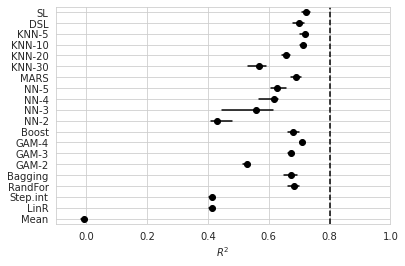

In [3]:
results = pd.DataFrame(index=range(sims),
                       columns=labels + ["DSL", "SL"])

for i in range(sims):
    run_single_sim(i, n_obs=100, version=1, results=results)

plot_results(results)
plt.show()

## Mechanism 2

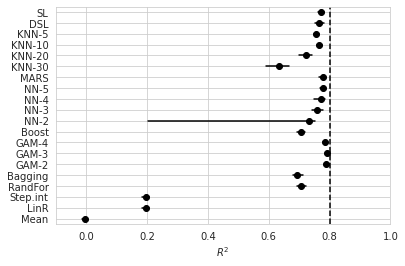

In [4]:
results = pd.DataFrame(index=range(sims),
                       columns=labels + ["DSL", "SL"])

for i in range(sims):
    run_single_sim(i, n_obs=100, version=2, results=results)

plot_results(results)
plt.show()

## Mechanism 3

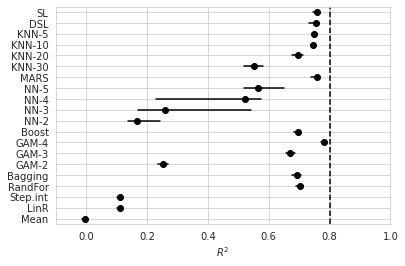

In [5]:
results = pd.DataFrame(index=range(sims),
                       columns=labels + ["DSL", "SL"])

for i in range(sims):
    run_single_sim(i, n_obs=100, version=3, results=results)

plot_results(results)
plt.show()

## Mechanism 4

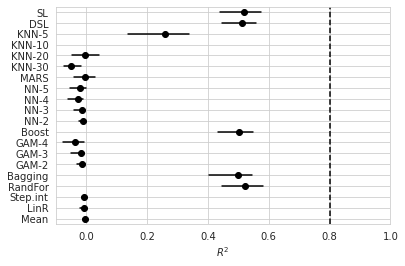

In [6]:
results = pd.DataFrame(index=range(sims),
                       columns=labels + ["DSL", "SL"])

for i in range(sims):
    run_single_sim(i, n_obs=100, version=4, results=results)

plot_results(results)
plt.show()

### Mechanism 4 with different $n$'s for the training set

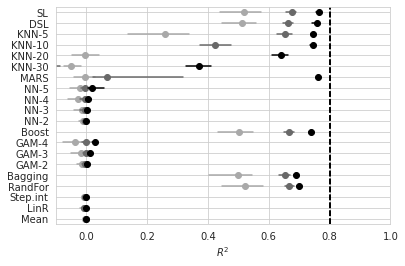

In [7]:
# n = 100: plot results from previous cell
plot_results(results, color='darkgray')  # darkgray is actually light

# n = 200
results = pd.DataFrame(index=range(sims),
                       columns=labels + ["DSL", "SL"])
for i in range(sims):
    run_single_sim(i, n_obs=200, version=4, results=results)

plot_results(results, color='dimgray')

# n = 500
results = pd.DataFrame(index=range(sims),
                       columns=labels + ["DSL", "SL"])
for i in range(sims):
    run_single_sim(i, n_obs=500, version=4, results=results)

plot_results(results, color='k')
plt.show()

# Super Learner with Binary Target

The following is a demonstration of `SuperLearner` with a binary target instead of a continuous target. It essentially uses the same models as before, but applies a logit transformation. This was not in any of the previously mentioned papers (and is my own sanity check).

For evaluation, accuracy is used instead of $R^2$ for evaluation.



In [8]:
import warnings
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn
from scipy.stats import logistic

from sklearn.linear_model import LogisticRegression
from pygam import LogisticGAM, s
from sklearn.ensemble import (RandomForestClassifier, BaggingClassifier,
                              GradientBoostingClassifier)
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from pyearth import Earth
from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score
from sklearn.exceptions import ConvergenceWarning
from zepid.superlearner import EmpiricalMeanSL, StepwiseSL, SuperLearner

warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)  # Neural-net warnings
warnings.simplefilter("ignore", category=RuntimeWarning)  # GAM warnings

sims = 100
labels = ["Mean", "LogR", "Step.int", "RandFor", "Bagging", "GAM-2", "GAM-3", "GAM-4", "Boost",
          "NN-2", "NN-3", "NN-4", "NN-5", "MARS", "KNN-30", "KNN-20", "KNN-10", "KNN-5"]

In [9]:
def dgm_binary(n, version):
    x = np.random.uniform(-4, 4, size=n)

    if version == 1:
        pr_y = logistic.cdf(-1.5 - 2*np.where(x < -3, 1, 0) + 
                            2.55*np.where(x > -2, 1, 0) - 2*np.where(x > 0, 1, 0) +
                            4*np.where(x > 2, 1, 0) - np.where(x > 3, 1, 0))
    elif version == 2:
        pr_y = logistic.cdf(2 + 0.4*x - 0.36*(x**2) + 0.005*(x**3))
    elif version == 3:
        pr_y = logistic.cdf(2.83*np.sin(np.pi / 2 * x))
    elif version == 4:
        pr_y = logistic.cdf(4*np.sin(3*np.pi*x)*np.where(x>0, 1, 0))
    else:
        raise ValueError("Invalid dgm version")

    y = np.random.binomial(n=1, p=pr_y, size=n)
    d = pd.DataFrame()
    d['X'] = x
    d['pY'] = pr_y
    d['Y'] = y
    return d


def run_single_sim(i, n_obs, version, results):
    obs_data = dgm_binary(n=n_obs, version=version)
    x_train = np.asarray(obs_data['X']).reshape(-1, 1)
    y_train = np.asarray(obs_data['Y'])
    oos_data = dgm_binary(n=10000, version=version)
    x_test = np.asarray(oos_data['X']).reshape(-1, 1)
    y_test = np.asarray(oos_data['Y'])

    # Mean
    emp = EmpiricalMeanSL()
    emp.fit(x_train, y_train)
    y_pred_emp = np.where(emp.predict(x_test) > 0.5, 1, 0)
    results.loc[i, "Mean"] = accuracy_score(y_test, y_pred_emp)

    # Logistic Regression
    ols = LogisticRegression(fit_intercept=True)
    ols.fit(x_train, y_train)
    y_pred_ols = ols.predict(x_test)
    results.loc[i, "LogR"] = accuracy_score(y_test, y_pred_ols)

    # Stepwise
    f = sm.families.family.Binomial()
    step = StepwiseSL(f, selection="backward", order_interaction=1)
    step.fit(x_train, y_train)
    y_pred_step = np.where(step.predict(x_test) > 0.5, 1, 0)
    results.loc[i, "Step.int"] = accuracy_score(y_test, y_pred_step)

    # Random Forest
    randf = RandomForestClassifier()
    randf.fit(x_train, y_train)
    y_pred_rf = randf.predict(x_test)
    results.loc[i, "RandFor"] = accuracy_score(y_test, y_pred_rf)

    # Bagging
    bagr = BaggingClassifier()
    bagr.fit(x_train, y_train)
    y_pred_bag = bagr.predict(x_test)
    results.loc[i, "Bagging"] = accuracy_score(y_test, y_pred_bag)

    # GAM -- 2
    gam2 = LogisticGAM(s(0, n_splines=5, spline_order=1), lam=1)
    gam2.fit(x_train, y_train)
    y_pred_gam2 = gam2.predict(x_test)
    results.loc[i, "GAM-2"] = accuracy_score(y_test, y_pred_gam2)

    # GAM -- 3
    gam3 = LogisticGAM(s(0, n_splines=10, spline_order=2), lam=1)
    gam3.fit(x_train, y_train)
    y_pred_gam3 = gam3.predict(x_test)
    results.loc[i, "GAM-3"] = accuracy_score(y_test, y_pred_gam3)

    # GAM -- 4
    gam4 = LogisticGAM(s(0, n_splines=20), lam=1)
    gam4.fit(x_train, y_train)
    y_pred_gam4 = gam4.predict(x_test)
    results.loc[i, "GAM-4"] = accuracy_score(y_test, y_pred_gam4)

    # Boosting
    gbr = GradientBoostingClassifier()
    gbr.fit(x_train, y_train)
    y_pred_gbr = gbr.predict(x_test)
    results.loc[i, "Boost"] = accuracy_score(y_test, y_pred_gbr)

    # Neural Network -- 2 nodes
    nn2 = MLPClassifier(hidden_layer_sizes=(2,), solver='lbfgs', max_iter=2000)
    nn2.fit(x_train, y_train)
    y_pred_nn2 = nn2.predict(x_test)
    results.loc[i, "NN-2"] = accuracy_score(y_test, y_pred_nn2)

    # Neural Network -- 3 nodes
    nn3 = MLPClassifier(hidden_layer_sizes=(3,), solver='lbfgs', max_iter=2000)
    nn3.fit(x_train, y_train)
    y_pred_nn3 = nn3.predict(x_test)
    results.loc[i, "NN-3"] = accuracy_score(y_test, y_pred_nn3)

    # Neural Network -- 4 nodes
    nn4 = MLPClassifier(hidden_layer_sizes=(4,), solver='lbfgs', max_iter=2000)
    nn4.fit(x_train, y_train)
    y_pred_nn4 = nn4.predict(x_test)
    results.loc[i, "NN-4"] = accuracy_score(y_test, y_pred_nn4)

    # Neural Network -- 5 nodes
    nn5 = MLPClassifier(hidden_layer_sizes=(5,), solver='lbfgs', max_iter=2000)
    nn5.fit(x_train, y_train)
    y_pred_nn5 = nn5.predict(x_test)
    results.loc[i, "NN-5"] = accuracy_score(y_test, y_pred_nn5)

    # MARS
    EarthClassifier = Pipeline([('earth', Earth()),
                                ('logistic', LogisticRegression())])
    EarthClassifier.fit(x_train, y_train)
    y_pred_mars = EarthClassifier.predict(x_test)
    results.loc[i, "MARS"] = accuracy_score(y_test, y_pred_mars)

    # KNN - 75NN
    knn75 = KNeighborsClassifier(n_neighbors=30)
    knn75.fit(x_train, y_train)
    y_pred_knn75 = knn75.predict(x_test)
    results.loc[i, "KNN-30"] = accuracy_score(y_test, y_pred_knn75)

    # KNN - 50NN
    knn50 = KNeighborsClassifier(n_neighbors=20)
    knn50.fit(x_train, y_train)
    y_pred_knn50 = knn50.predict(x_test)
    results.loc[i, "KNN-20"] = accuracy_score(y_test, y_pred_knn50)

    # KNN - 25NN
    knn25 = KNeighborsClassifier(n_neighbors=10)
    knn25.fit(x_train, y_train)
    y_pred_knn25 = knn25.predict(x_test)
    results.loc[i, "KNN-10"] = accuracy_score(y_test, y_pred_knn25)

    # KNN - 10NN
    knn10 = KNeighborsClassifier(n_neighbors=5)
    knn10.fit(x_train, y_train)
    y_pred_knn10 = knn10.predict(x_test)
    results.loc[i, "KNN-5"] = accuracy_score(y_test, y_pred_knn10)

    # Discrete Super Learner
    candidates = [EmpiricalMeanSL(),
                  LogisticRegression(fit_intercept=True),
                  StepwiseSL(f, selection="backward", order_interaction=1),
                  RandomForestClassifier(),
                  BaggingClassifier(),
                  LogisticGAM(s(0, n_splines=2, spline_order=1), lam=0.5),
                  LogisticGAM(s(0, n_splines=3, spline_order=2), lam=0.5),
                  LogisticGAM(s(0, n_splines=4), lam=0.5),
                  GradientBoostingClassifier(),
                  MLPClassifier(hidden_layer_sizes=(2,), solver='lbfgs', max_iter=2000),
                  MLPClassifier(hidden_layer_sizes=(3,), solver='lbfgs', max_iter=2000),
                  MLPClassifier(hidden_layer_sizes=(4,), solver='lbfgs', max_iter=2000),
                  MLPClassifier(hidden_layer_sizes=(5,), solver='lbfgs', max_iter=2000),
                  Pipeline([('earth', Earth()), ('logistic', LogisticRegression())]),
                  KNeighborsClassifier(n_neighbors=75),
                  KNeighborsClassifier(n_neighbors=50),
                  KNeighborsClassifier(n_neighbors=25),
                  KNeighborsClassifier(n_neighbors=10)]

    dsl = SuperLearner(candidates, labels, loss_function="nloglik", folds=5, discrete=True, verbose=False)
    dsl.fit(x_train, y_train)
    # dsl.summary()
    y_pred_dsl = np.where(dsl.predict(x_test) > 0.5, 1, 0)
    results.loc[i, "DSL"] = accuracy_score(y_test, y_pred_dsl)

    # Super Learner
    candidates = [EmpiricalMeanSL(),
                  LogisticRegression(fit_intercept=True),
                  StepwiseSL(f, selection="backward", order_interaction=1),
                  RandomForestClassifier(),
                  BaggingClassifier(),
                  LogisticGAM(s(0, n_splines=2, spline_order=1), lam=0.5),
                  LogisticGAM(s(0, n_splines=3, spline_order=2), lam=0.5),
                  LogisticGAM(s(0, n_splines=4), lam=0.5),
                  GradientBoostingClassifier(),
                  MLPClassifier(hidden_layer_sizes=(2,), solver='lbfgs', max_iter=2000),
                  MLPClassifier(hidden_layer_sizes=(3,), solver='lbfgs', max_iter=2000),
                  MLPClassifier(hidden_layer_sizes=(4,), solver='lbfgs', max_iter=2000),
                  MLPClassifier(hidden_layer_sizes=(5,), solver='lbfgs', max_iter=2000),
                  Pipeline([('earth', Earth()), ('logistic', LogisticRegression())]),
                  KNeighborsClassifier(n_neighbors=75),
                  KNeighborsClassifier(n_neighbors=50),
                  KNeighborsClassifier(n_neighbors=25),
                  KNeighborsClassifier(n_neighbors=10)]
    sl = SuperLearner(candidates, labels, loss_function="nloglik", folds=5, discrete=False, verbose=False)
    sl.fit(x_train, y_train)
    # sl.summary()
    y_pred_sl = np.where(sl.predict(x_test) > 0.5, 1, 0)
    results.loc[i, "SL"] = accuracy_score(y_test, y_pred_sl)
    
    return results


## Mechanism 1

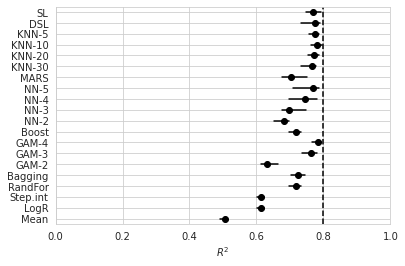

In [10]:
results = pd.DataFrame(index=range(sims),
                       columns=labels + ["DSL", "SL"])

for i in range(sims):
    run_single_sim(i, n_obs=100, version=1, results=results)

plot_results(results, xlims=(0.0, 1.0))
plt.show()

## Mechanism 2

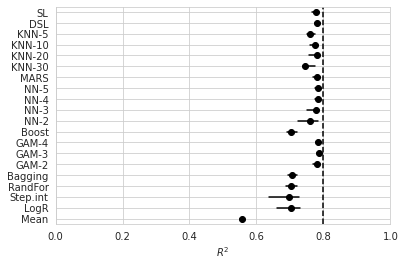

In [11]:
results = pd.DataFrame(index=range(sims),
                       columns=labels + ["DSL", "SL"])

for i in range(sims):
    run_single_sim(i, n_obs=100, version=2, results=results)

plot_results(results, xlims=(0.0, 1.0))
plt.show()

## Mechanism 3

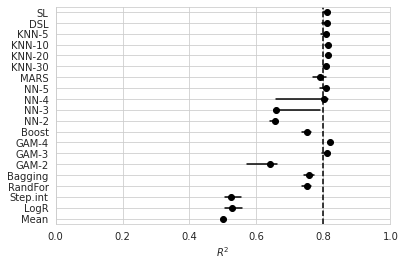

In [12]:
results = pd.DataFrame(index=range(sims),
                       columns=labels + ["DSL", "SL"])

for i in range(sims):
    run_single_sim(i, n_obs=100, version=3, results=results)

plot_results(results, xlims=(-0.0, 1.0))
plt.show()

## Mechanism 4

did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge


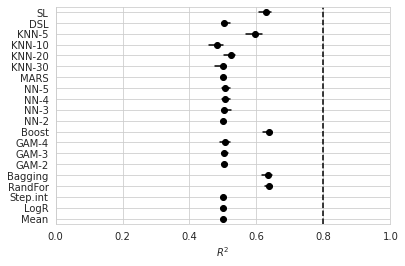

In [13]:
results = pd.DataFrame(index=range(sims),
                       columns=labels + ["DSL", "SL"])

for i in range(sims):
    run_single_sim(i, n_obs=100, version=4, results=results)

plot_results(results, xlims=(0.0, 1.0))
plt.show()

### Mechanism 4 with different $n$'s for the training set

did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not conver

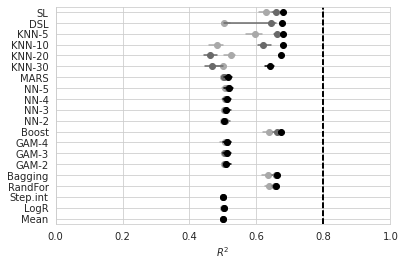

In [14]:
# n = 100
plot_results(results, xlims=(0.0, 1.0), color='darkgray')  # darkgray is actually light

# n = 200
results = pd.DataFrame(index=range(sims),
                       columns=labels + ["DSL", "SL"])
for i in range(sims):
    run_single_sim(i, n_obs=200, version=4, results=results)

plot_results(results, xlims=(0.0, 1.0), color='dimgray')

# n = 500
results = pd.DataFrame(index=range(sims),
                       columns=labels + ["DSL", "SL"])
for i in range(sims):
    run_single_sim(i, n_obs=500, version=4, results=results)

plot_results(results, xlims=(0.0, 1.0), color='k')
plt.show()